# Applied Deep Learning Tutorial 
contact: Mark.schutera@kit.edu


# Segmentation with U-Net

## Introduction
This tutorial presents a segmentation use-case based on U-Net network (see paper for reference [paper](https://arxiv.org/pdf/1505.04597.pdf)).
First, the theoretical background behind the architecture is discussed. Subsequently you will be guided through the implementation process of the neural network within this Jupyter Notebook. The use-case is based on the initial paper and focuses on cell boundary segmentation, see Fig.1.
<img src="graphics/unet_fig_1.png" width="700"><br>
<center> Figure 1: Right: input image | Left: Prediction of the cell boundaries </center>

## Motivation

While segmentation networks and convolutional neural networks often need a very large amount of training data in order to converge, it is necessary to deploy the training data more efficiently. In segmentation, objects need to be localized and classified. This requires improved semantic understanding. 
The U-Net achieves sample efficiency while capturing both class affiliations and localization performance.  

## U-Net Architecture

<img src="graphics/unet_fig_2.png" width="700"><br>
<center> Figure 2: U-Net architecture </center>

In Fig.2, the architecture of the U-Net is shown. The name is derived from the U-shaped architecture of the downsampling and the upsampling path. The input to the U-Net is an image tile. An image is processed one tile after another. In this manner, the image can be of an arbitrarily large size and for example and its size is not linked to the memory capabilities of your GPU. An example of such a tile can be seen in Fig.3 below.
<img src="graphics/unet_fig_3.png" width="300">


<center> Figure 3: Tile of an image </center>
A tile of an input image is shown. The convolution has no padding, thus the yellow box, the center of the tile, gets a segment prediction output while the blue region is the region which is fed into the neural network. 

The convolutions marked with the blue arrows within Fig.2 process the input by building feature maps of the shown size. These convolution a ReLu function is followed. After the first 3 convolutions a feature map of the size 568x568x64 is received. Thereafter max-pooling operation (2x2 with a stride of 2), marked with red arrows in the image, downsample the image size but simultaneously doubles the size of the feature map.<br>
This is repeated until we get a single vector with a high resolution feature map. Thus this contracting path reduces the information of the location by simultaneously increase the context information (features). From this high resolution feature vector, now a high resolution segmentation-map with a high accuracy of the location is built. This is done by expand the vector with up-sampling, due up-convolution and with, and this is the novelty, concatenate the high resolution feature map from the contracting path. This is shown with the grey arrows seen in the Fig.2. Furthermore after every upconcolution a ReLU operation is appended. 
With this combination of knotting the upconcolution of the high resolution feature map with the localization information, it is not getting loss as it is the case with just do an "autoencoding". <br>
Due to the aforementioned loss of information with the nonpadded convolution, the feature map needs to be cropped.
The final layer consists out of a 1x1 convolution which maps each 64 component feature vector to the desired number of classes. And thus devide the image into the requested segments. 

## Implementing the code 

We will orientate with this tutorial on the implemtation of the code from [this](https://github.com/zhixuhao/unet) github repository.
Due to the implementation in Jupyter Notebook we will write the whole code in one template. Instead of different python documents we will use classes.
The original repository consists out of three python documents. To work only with this notebooky every function is integrated here, thus you don't have to switch documents or import other python-files.


In [1]:
# If you do not have the data yet, you can download it here:
# https://github.com/zhixuhao/unet/tree/master/data/membrane
# Now go to the folder in which this jupyter Notebook ist located and running
# and copy the <<data>> folder there and renaming either the folders according 
# to the Path written below or change the path written below according to
# your folder-names

!git clone https://github.com/zhixuhao/unet.git

Cloning into 'unet'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394
Receiving objects: 100% (394/394), 44.92 MiB | 36.19 MiB/s, done.
Resolving deltas: 100% (80/80), done.


When you run the Code below and you set the Path accordingly, an image and its label should be shown.

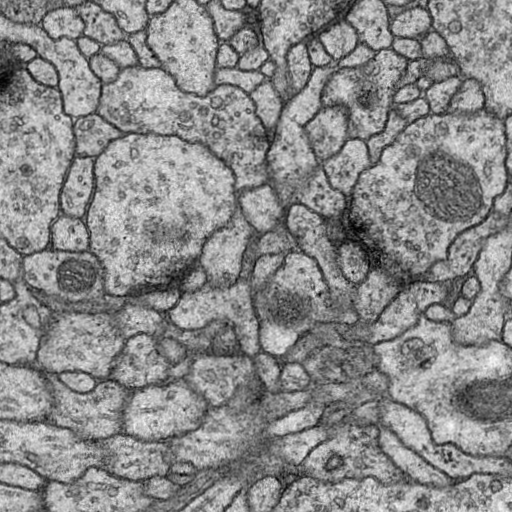

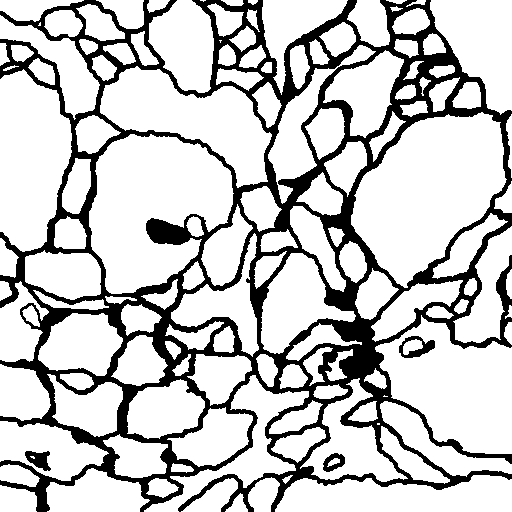

In [2]:
##########################################################
#           In this box some code must be added          #
##########################################################
from IPython.display import Image
#We want to see one of the training data with its label
# Change the folders or the code that the path points to your data
training_images = 'unet/data/membrane/train/image/'
training_labels = 'unet/data/membrane/train/label/'

#We use the function Image(file_name) to print the image '0.png' and the label 'o.png'
display(Image(training_images + '0.png'))
display(Image(training_labels + '0.png'))


### Buidling the Unet Architecture

In the next box all libraries and packages we will need for the U-Net and its data prepration will be imported. 
Because Keras is a part of tensorflow and is installed within, it comes preinstalled with tensorflow <br>
"tensorflow.keras"

If something went wrong with importing the packages, you can try to restart your kernel.

In [3]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os 
import glob
import skimage.io as io #pip install scikit-image pip install scipy within your conda environment
# if This Error occurs:
# <<ImportError: cannot import name 'rgb2gray'>>
# restart your kernel
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

To build the archtecture which is shown in fig.1 keras is a very intuitive and simply way to do so. We will slithly adapt the archtecture from the original one like seen in fig.3. To build this neural net we do need the following functions:
- 2D Convolution
- MaxPooling 
- Concatenation

We will add an Dropout after convolution 4 and 5,  please explain what could be the purpose to add those two layers?





*Dropout prevents all the layers from synchronously activating their weights. This prevents all the neurons from converging to the same goal, thus decorrelating the weights.*


Let's start coding the Network with the following functions:

- Conv2D(filters/feature maps, kernel size, activation, padding, kernel_initializer)(input Data)
- MaxPooling2D(pool_size = (x,x))(input Data)
- Dropout(dropout rate)(input Data)
- concatenate([input Data 1, Input Data 2], axis= x)
- Conv2D()(UpSampling2D(size=(x,x))(Input Data)

As activation function we take 'relu' (Rectified Linear Unit).
As padding we chose 'same', thus despite convolution we get an output of the same size as the input.
The kernel initializer defines how we want to set the initial weights of this Keras layer. For example:
- Zeros: initialize with a tensor of zeros
- Ones: initialize with a tensor of ones
- RandomNormal: initialize the tensor with a normal distribution
- TruncatedNormal: initialize the tensor with a truncated normal distribution, where all values more than two standard deviations from its mean are neglected
- he_normal: a zero mean Gaussian distribution with a standard deviation of \sqrt{(2/n)}, where n is the number of inputs/connections of our weight tensor <br>

Which initialization do you think is beneficial?


*We cannot say which is better and which is not they have their own advantages and disadvantages.Usually based on the activation function the initializer is chosen. For example if using ReLU we prefer he_normal*



When the architecture is configured correctly we have to define the inputs and outputs of our Neural Network with the method: <br> Model(inputs= ___ , outputs= __).
Thereafter we need to compile the whole architecture for training. Therefore we need to define the optimizer, the learning rate, the loss function and we can determine on which metrics we want to evaluate our model. 

List 3 loss functions and 3 optimizers and explain them:


**Loss Functions:**


1.   Mean Squared Error: Used for Regression problems. Preferred loss function under the inference framework of maximum likelihood if the distribution of the target variable is Guassian.
2.   Binary Cross Entropy Loss: Used for Binary Classification. Cross-Entropy will calculate a score that summarizes the average difference between the actual and predicted probabilitz distributions for predicting class 1.
3.  Hinge Loss: Alternative to BCNL used for SVM's. It encourages examples to have correct sign, assigning more error when there is a difference in the sign between the actual and predicted class values.

**Optimizers:**


1.   RMSprop: It accumulates gradients in a fixed window.
2.   Adam: It stands for Adaptive moment estimate, it utilizes the concept of momentum by adding fractions of previous gradients to the current one.
3.   Stochastic Gradient Descent: It tries to update the model's parameters more frequently. 



Choose one of these optimizers you thing fit best for your U-Net and experiment with the learning rate.
The return of our function should be the model.


## The Dice Coefficient Loss

In this section we will implement the Dice Coefficient loss, so we can use it with our own model.
The Dice Coefficient, also known as Sørensen–Dice coefficient compares the similarity of two quantities. When working with neural network we want to compare the prediction of our network and the ground truth. The dice coefficient can be interpreted as Intersection over union, this makes it intuitive to interpret and a direct loss function for segmentation errors.
<br>
The equation of the dice loss is given with:
\begin{align}
    DSC = \frac{2*|X \cap Y|}{|X|+|Y|}
\end{align}

Before coding this equation you may think about:
   - do I need the absolute values?
   - how can i easily calculate the intersection, assuming that the ground truth is a one-hot vector:
    \begin{align}
        y_{true} = \begin{bmatrix}
        0.0 &  0.0 &  0.0 &  1.0
        \end{bmatrix}
    \end{align}
    \begin{align}
        y_{pred} = \begin{bmatrix}
        0.1 &  0.2 &  0.0 &  0.7
        \end{bmatrix}
    \end{align}
<br>

Now start with the coding, following these steps: 
- First we want to flatten our input to the loss y_true and y_pred
- Calculate the counter with its intersection
- Calulate the denominator, (you may want to add a small epsilon to it)
- Obtain the coefficient

Because we work here with the backend of keras, we need to do our calculations with K.operation.
K is the backend we imported above with "from tensorflow.keras import backend as K".
Here a list of some operations is listed, if you need more, just google them:
- sum: K.sum()
- flatten: K.flatten()
- mean: K.mean()
- reshape: K.reshape()
- dot: K.dot()
- epsilon: K.epsilon()

In [4]:
def dice_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten*y_pred_flatten)
    nominator = 2. * intersection + K.epsilon()
    denominator = K.sum(y_true_flatten) + K.sum(y_pred_flatten) + K.epsilon()
    coef = nominator/denominator
    return coef

Why it is advised to add an epsilon to your denominator?


It is important to add an epsilon to denominator as well as nominator as if the y_true and y_pred values are similar then we get 1 if completely different then we get 0 to avoid this we add a very small value to avoid error.

In [5]:

def dice_coef_loss(y_true, y_pred):
    dice_coef_loss = 1 - dice_coef(y_true, y_pred)
    return dice_coef_loss

In [6]:
##########################################################
#           In this box some code must be added          #
##########################################################

def unet(pretrained_weights=None, input_size=(256, 256, 1)): #the values given for the parameters are the default values
    inputs = Input(input_size)
    # complete the missing layers (your may use the lines below the ones to fill in, if you are stuck)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    #Maxpooling with 2x2
    pool1 = MaxPooling2D(pool_size=((2,2)))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    
    
    ################################################################################################
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    ################################################################################################
    
    # Here add a Dropout of 0.5
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    ################################################################################################
    # Here we will start with the upconvolution 
    ################################################################################################
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2,2))(drop5)
        #____ insert the input of this first upsampling layer with using the function:
        # << UpSampling2D()>> with the same size as the MaxPooling layers and as input the according layer.
        )
    # Because we now have the output of our UpConvolution but also we need the spatial information from the 
    # convolutional layers and MaxPooling we have to merge these two inputs with the function <<concatenate>> 
    # Figurativly speaking merge the gray and green arrows from Fig. 2
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # In the last layer we chose the <sigmoid> as activation function because the output has to be between zero and one.
    # We normalized out pixle values by deviding through 255.
    # For our example we have only one class and thus only needing
    # zero being white (our predicted object-segment) and 1 beeing black. 
    # but if we have more that one class the different colors will also lie inbetween 0 and 1 and every
    # prediction is labeld with the appropriate number. 
    
    # Choose a function for your last layer which fullfill the requirements for classification at its best
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # With the following method <Model> we define out input and output of or Neural Network
    # please complete:
    model = Model(inputs=inputs, outputs=conv10)

    # with Model.compile we configure and prepare our network for training. Thus we define our optimizer for 
    # learning with it's learning rate, the loss function and the metrics.
    # Choose a loss you think fits best for this kind of task and also do so for the optimizer
    # if your own coded optimizer and loss should be used you have to implement them accoridingly  
    model.compile(optimizer=Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

    # model.summary()
    
    # this part we need for resume to a training or printing test, results for an already trained network, be careful
    # that the input_size you defined for the model match with the one you defined for the model you take the pretrained
    # weights from!
    # Here you can play with some provided networks for more difficult tasks and do not train them expensivly on your own 
    # Computer
    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

### Preparing the Data

So far we build the architecture of our neural net and the data, consists out of images and labels. To train the neural network in the next step the data has to be prepared.

First of all we define a color map for our labels. With this map we define a specific mask-color for each of the appearing objects. 
Because we only have one ground truth label, the boundaries of the cell, we do not really need a color map. But as you can use this code for other task and to familiar with such a Color dicitonary some COLOR_DICT is given below.

In [7]:
# this part below assign the labeling color for the predictions to the labels
# for our purpose it is not really important because we only have "unlabelled" labels, but if you want to experiment
# with other data you might can use and easily adapt this
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

#### Adjusting the Data

Before we feed the data to our neural network, it has to be adjusted properly. 
The first step always helps is to normalize our input data. Important is to normalize both the labels and the images, so that the neural network does not learn something wrong, warped or even nothing at all.
As said befor this code can also used to implement multiple classes, and therefore needs a flag whether the input is multi class (flag_multi_class = True) or just binary. 
In this tutorial we got the binary case and therefor the images and masks just need to be normalized.
This is done by dividing through 255. 
To get the mask as one-hot vector, we need to convert it. Every mask value > 0.5 should be 1 and every mask value <= 0.5 should be 0. This has to be done below.

In [8]:
##########################################################
#           In this box some code must be added          #
##########################################################
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        # normalize the image
        img = img / 255
        # normalize the mask 
        mask = mask /255
        # convert your mask vector into a one-hot vector 
        mask[mask > 0.5] = 1 #1-hot vector (True)
        mask[mask <= 0.5] = 0 # 1-hot vector(False)
    return (img,mask)

#### The training Generator

The next function will be the "trainGenerator".
Because deep learning tasks only get to learn something if they are trained with a lot of data, we have to provide it. But with the data we downloaded, there are only 30 images in the folder train/. For a deep learning task that is way too little. Therefore we will generate our own data with data augmentation. This function will do the data augmentation on the given images with functions like rotation, shear and zoom etc. It is important that the ground truth and input images are transformed together with the same transformation functions.

How far we can get with augmentation depends on the data and task at hand. But for the given task data augmentation really does its part.
This is also due to cropping multiple times from a single image, which supports with multiple object instances in a single sample.

To save the data augmentation results, if you want to look at them you can set the save_to_dir to the path where you want to save them.
The utilized data augmentation approach is the ImageDataGenertor pipeline provided within Keras. This function takes a dictionary of arguments to augmentate your data. The documentations for more information can be found here 
https://keras.io/preprocessing/image/.

Why is it important to set the same seed for the mask and the image and what does seed stand for?


In [9]:
##########################################################
#           In this box some code must be added          #
##########################################################
#change save_to_dir to your output path if you do not want to save the output of the trainings Generator the path
# is "None"
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    # the generated masks and images are now passed on the function <<adjustData>> discussed beforehand
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
        
# to understand what yield is: https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do

#### The Testing Generator

The testGenerator function will generate your test data on the images provided within the test folder. 
It will first read the images from the test-folder as gray images normalize them and resize them like defined in with the parameter target_size. Depending on the amount of object-classes you need the image vector will be extended. For our purpose again it is not necessary.  

In [10]:
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

#### The visualizer of the labels and predictions

In [11]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

#### Saving the results

In [12]:
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

## Run the training

Now all functions we need to run our Unet are defined and thus we can start the training.

First we need to augmentate our dataset which contains up to now only 30 images.
Therefor we can define some parameters within out data augmentation dictionary "data_gen_args" for this augmentation. To get some results and not just a gray image as prediciton, you should start with small parameters here.

Then we will generate the data with the beforehand defined parameters and the images given in the training folder. 
The first number hereby defines the batch_size, which you can change to a bigger number if your Computer fill in the requirements (GPU, Memory).

Now it is time to built our UNet with just calling the function and than start the traing.
You can change the "steps_per_epoch" and "epochs". The more you chose the better the results will get but also the longer the training will take.
The Checkpoint-file will be saved within your Jupter Notebook folder.

In [13]:
##########################################################
#           In this box some code must be added          #
##########################################################
# if it fails to run the training on your tensorflow-gpu 
# rerun it on a tensorflow cpu version

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.02,
                    height_shift_range=0.02,
                    shear_range=0.02,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'./unet/data/membrane/train','image','label',data_gen_args,save_to_dir = None)

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
# Try to start your training with x steps per epoch with y epochs
model.fit_generator(myGene,steps_per_epoch=200,epochs=5,callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
122/200 [=================>............] - ETA: 20:07 - loss: 0.5570 - accuracy: 0.7669

KeyboardInterrupt: ignored

## Test your Model

When the training is done you can generate some prediction on your test data and save them within the test-image folder.

In [ ]:
testGene = testGenerator("./unet/data/membrane/test")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("./unet/data/membrane/test",results)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


30/30 [==============================] - 35s 1s/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/0_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/1_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/2_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/3_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/4_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membra

### Show the results

We can now either look in the folder how well our network was trained or just show some images and their predicitons here:
If your prediction is just a gray image, your model wasn't trained good enough, and you might want to change some parameters (first of all steps_per_epoch and epochs)

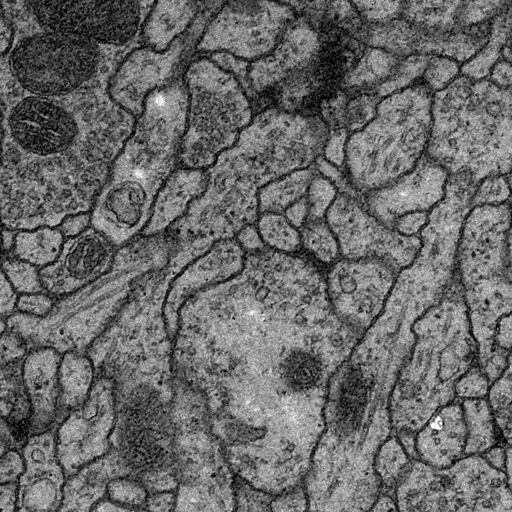

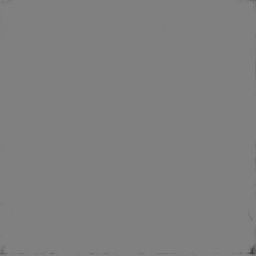

In [ ]:
test_images_path = "./unet/data/membrane/test/"
# number 0 to 29 your want to show
img_number = 24
display(Image(test_images_path + str(img_number) + '.png'))
display(Image(test_images_path + str(img_number)  + '_predict.png'))

Here you can load a pretrained net and test your data on it:

In [ ]:
# load the pretrained net within the folder
model = unet(pretrained_weights='unet_membrane.hdf5')
testGene = testGenerator("./unet/data/membrane/test")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("./unet/data/membrane/test",results)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


30/30 [==============================] - 35s 1s/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/0_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/1_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/2_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/3_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membrane/test/4_predict.png is a low contrast image
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: ./unet/data/membra

In [ ]:
# show results with this weights
test_path = "./unet/data/membrane/test"
# number 0 to 29 your want to show
img_number = 5
display(Image(test_path + str(img_number) + '.png'))
display(Image(test_path + str(img_number)  + '_predict.png'))

## What's next

Some ideas of what you can do next

- Try on cars 
- try on dataset with multiple labels 
- try on zebrafish repository (https://osf.io/snb6p/)
- adapt architecture (loss, learning-rate,...)

**Pet Image Segmentation**

Image segmentation is to train a neural Network to output a pixwl-wise mask of the image. This has many applications in medical imaging , self-driving cars and satellite imaging etc.

Here we use the Oxford-IIIT Pet Dataset, which consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of the three categories:



Class 1: Pixel belonging to the pet.

Class 2: Pixel bordering the pet.   

Class 3: None of the above/ Surrounding pixel.

https://www.tensorflow.org/tutorials/images/segmentation

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-7t9p_9cr
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-7t9p_9cr
  Created wheel for tensorflow-examples: filename=tensorflow_examples-220ff28b6f3f889434de83ee5185b7541ea7bc1d_-cp37-none-any.whl size=255893 sha256=eee88f56d31590640eacdf77c43a4141435972688be4b7e055242834c53e9c03
  Stored in directory: /tmp/pip-ephem-wheel-cache-cs1spe5c/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
#Download the dataset which is part of the Tensorflow datasets.
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteK20Y7W/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteK20Y7W/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
#Now we need to normalize the images [0,1]. The pixels in the segmentation masks are labeled either {1,2,4}. 
#For convenience subtracting 1 from the segmentation masks resulting in {0,1,2}.
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


In [6]:
#Simple augmentation of flipping the images
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
#The dataset is already split into test and train continuing to use the same.
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [11]:
#Display the image along with its segmentation mask
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

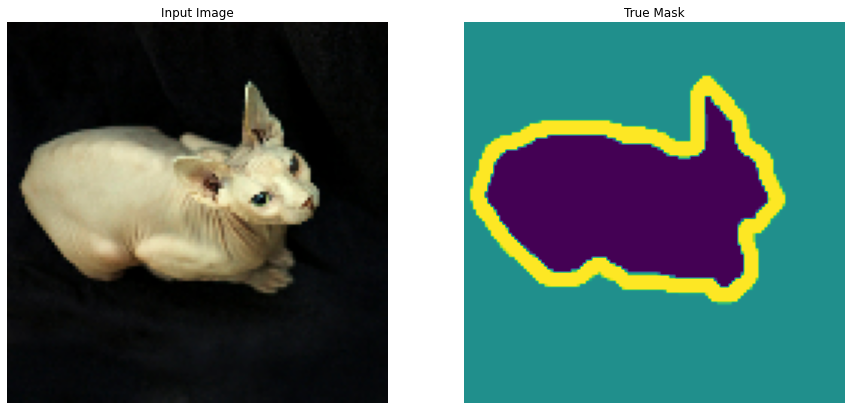

In [12]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [17]:
#Next we need the model. Here we use a modified U-Net. The U-Net consists of an encoder and decoder. 
#Here to learn roboust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder.
#Thus we are using a pretrained the MobileNetV2 model whose intermediate outputs will be used, decoder will be the upsample block  in Pix2Pix tutorial.

#There is a three channel output as there are three possible labels for each pixel.

OUTPUT_CHANNELS = 3

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [20]:
#The decoder block
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
#Compile and Train the model
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

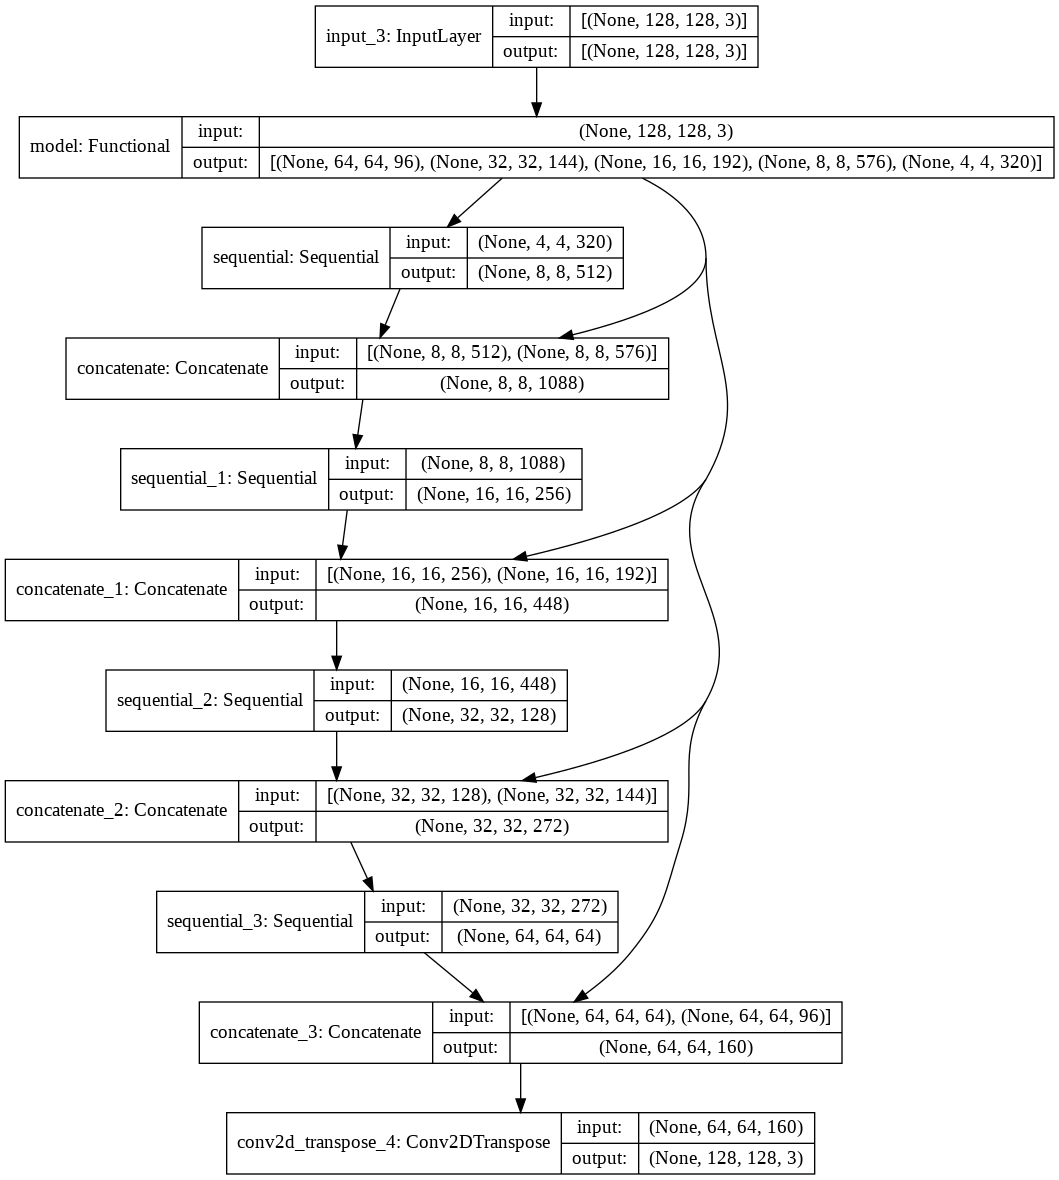

In [23]:
#Plotting the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
#Model predictions before the training
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [25]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

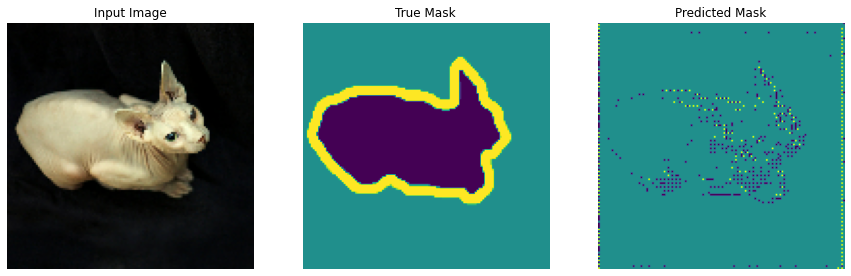

In [26]:
show_predictions()

In [27]:
#As observed the predictions of the model is very bad. Now let us observe the model improvements while it trains. 
#To achieve this we use a call back function.

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

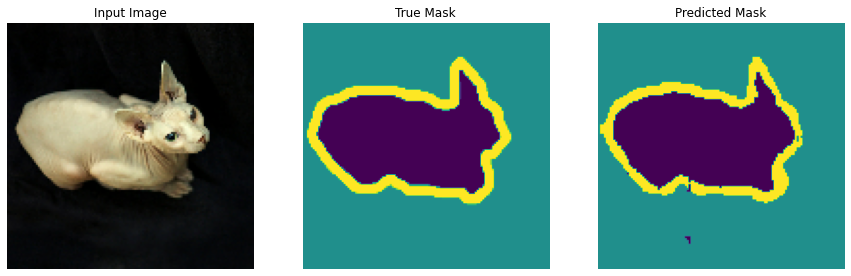


Sample Prediction after epoch 20



In [28]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

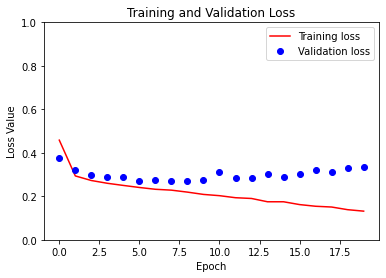

In [29]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

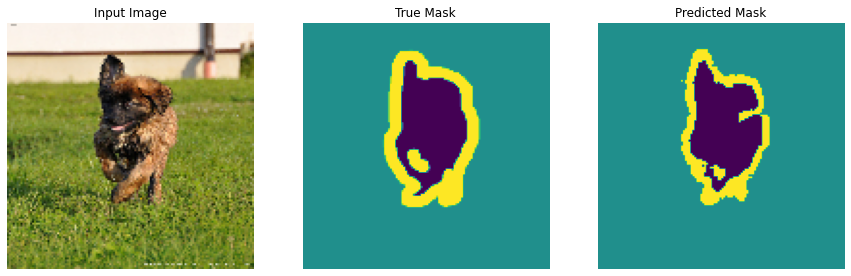

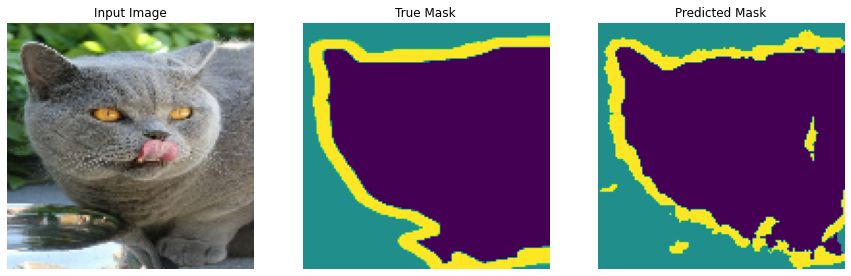

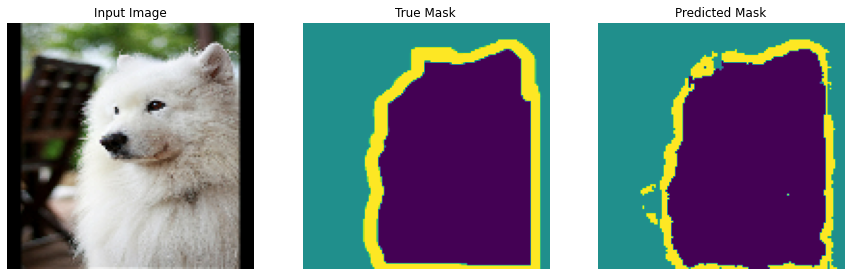

In [30]:
show_predictions(test_dataset, 3)

**CityScapes semantic Segmentation using Unet**

Here the semantic segmentation of Unet model is used to realize the urban landscape data scene which can be used in autonomous driving. The data is provided https://www.cityscapes-dataset.com/ This data is divided into the original image, the segmentation image, and includes the training set and the test set.

In the CityScapes data set there are 34 types of data output after semantic segmentation. Each one is a different object and different objects are marked with different colors.


0. unlabeled (0,0,0)
1. ego vehicle (0,0,0)
2. rectification border (0,0,0)
3. out of roi (0,0,0)
4. static (0,0,0)
5. dynamic (111,74,0)
6. ground (81,0,81)
7. road (128,64,128)
8. sidewalk (244,35,232)
9. parking (250,170,160)
10. rail track (230,150,140)
11. building (70,70,70)
12. wall (102,102,156)
13. fence (190,153,153)
14. guard rail (180,165,180)
15. bridge (150,100,100)
16. tunnel (150,120,90)
17. pole (153,153,153)
18. polegroup (153,153,153)
19. traffic light (250,170,30)
20. traffic sign (220,220,0)
21. vegetation (107,142,35)
22. terrain (152,251,152)
23. sky (70,130,180)
24. person (220,20,60)
25. rider (255,0,0)
26. car (0,0,142)
27. truck (0,0,70)
28. bus (0,60,100)
29. caravan (0,0,90)
30. trailer (0,0,110)
31. train (0,80,100)
32. motorcycle (0,0,230)
33. bicycle (119,11,32)





In [ ]:
# Data Pre-Processing

#import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import matplotlib.pyplot as plt
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Unzip the data
local_zip = '/content/gdrive/My Drive/gtFine_trainvaltest.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/cityscape')
zip_ref.close()

Note:

This work is not completed due to huge data size which couldn't be uploaded onto google colab. Will be attempted to complete this in the future.

https://www.programmersought.com/article/25815875383/

## Sources:<br>
[Fig2 - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)<br>
[Fig3 - https://arxiv.org/pdf/1505.04597.pdf](https://arxiv.org/pdf/1505.04597.pdf) <br>